In [27]:
#importare il necessario

import warnings
import math
import os
import random
import fbprophet
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML


pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")


logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
#Rolling - previsioni a corto termine
resultsRolling: dict = {'M01AB':[0.0,0.0],
     'M01AE':[0.0,0.0],
     'N02BA':[0.0,0.0],
     'N02BE':[0.0,0.0],
     'N05B':[0.0,0.0],
     'N05C':[0.0,0.0],
     'R03':[0.0,0.0],
     'R06':[0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index: list = ['Prophet MSE', 'Prophet MAPE']

#Previsioni a lungo termine
resultsLongterm: dict = {'M01AB':[0.0,0.0],
     'M01AE':[0.0,0.0],
     'N02BA':[0.0,0.0],
     'N02BE':[0.0,0.0],
     'N05B':[0.0,0.0],
     'N05C':[0.0,0.0],
     'R03':[0.0,0.0],
     'R06':[0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index: list = ['Prophet MSE', 'Prophet MAPE']

In [29]:
#Preparazione dei dati per le previsioni

df: list = pd.read_csv('./salesdaily.csv')

M01AB: dict = {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE: dict = {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA: dict = {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE: dict = {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B: dict = {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
N05C: dict = {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03: dict = {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06: dict = {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

r: list = [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg: list = df[['datum',x['series']]]
    dfg: list = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size: int = int(len(dfg) - 50)
    dfgtrain: list = dfg.loc[0:size,:]
    dfgtest: list = dfg.loc[size+1:len(dfg),:]
    predictions: list = list()
    minError: int = 0
    grid: list = ParameterGrid(x['params_grid'])
    for p in grid:
        model = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model = model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions: list = output.loc[size+2:len(dfg),:]['yhat'].values
        error: float = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError = error
                minP = p
        else:
            minError = error
            minP = p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

{'changepoint_prior_scale': 10, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AB): 9.918
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AE): 4.365
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N02BA): 2.377
{'changepoint_prior_scale': 50, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 170}
Test MSE (N02BE): 451.967
{'changepoint_prior_scale': 1, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05B): 16.098
{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05C): 1.132
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 120}
Test MSE (R03): 51.705
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 100}
Test MSE (R06): 7.945


In [37]:
# #Previsioni corto termine

# df: list = pd.read_csv('./salesdaily.csv')

# subplotindex: int = 0
# numrows: int = 4
# numcols:int = 2
# fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
# plt.subplots_adjust(wspace=0.1, hspace=0.3)

# warnings.filterwarnings("ignore")

# M01AB: dict = {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
# M01AE: dict = {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
# N02BA: dict = {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
# N02BE: dict = {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
# N05B: dict = {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
# N05C: dict = {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
# R03: dict = {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
# R06: dict = {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

# r: list = [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

# for x in r:
#     rowindex: int = math.floor(subplotindex/numcols)
#     colindex: int = subplotindex-(rowindex*numcols)
#     dfg: list = df[['datum',x['series']]]
#     dfg: list = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
#     size: int = len(dfg) - 50
#     dfgtrain: list = dfg.loc[0:size,:]
#     dfgtest: list = dfg.loc[size+1:len(dfg),:]
#     history: list = dfgtrain.copy()
#     predictions: list = list()
    
#     for t in dfgtest['ds'].values:
#         model = fbprophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
#                                   growth='linear', 
#                                   interval_width=x['params_grid']['interval_width'], 
#                                   daily_seasonality=False, 
#                                   weekly_seasonality=False
#                            )
#         if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
#             model = model.add_seasonality(
#                                 name='yearly',
#                                 period=365.25,
#                                 prior_scale=x['params_grid']['seasonality_prior_scale'],
#                                 fourier_order=13)
#         model_fit = model.fit(history)
#         future = model.make_future_dataframe(periods=1, freq='W')
#         output = model.predict(future)
#         yhat = output.loc[output.ds==t]['yhat'].values[0]
#         predictions.append(yhat)
#         obs = dfgtest.loc[dfgtest.ds==t]['y'].values[0]
#         dd = pd.DataFrame([[t,obs]],columns=['ds','y'])
#         history = history.append(dd)
        
#     error = mean_squared_error(dfgtest['y'].values, predictions)
#     perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
#     resultsRollingdf.loc['Prophet MSE',x['series']]=error
#     resultsRollingdf.loc['Prophet MAPE',x['series']]=perror
#     ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
#     ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
#     ax[rowindex,colindex].plot(dfgtest['y'].values)
#     ax[rowindex,colindex].plot(predictions, color='red')
#     subplotindex=subplotindex+1
# plt.show()

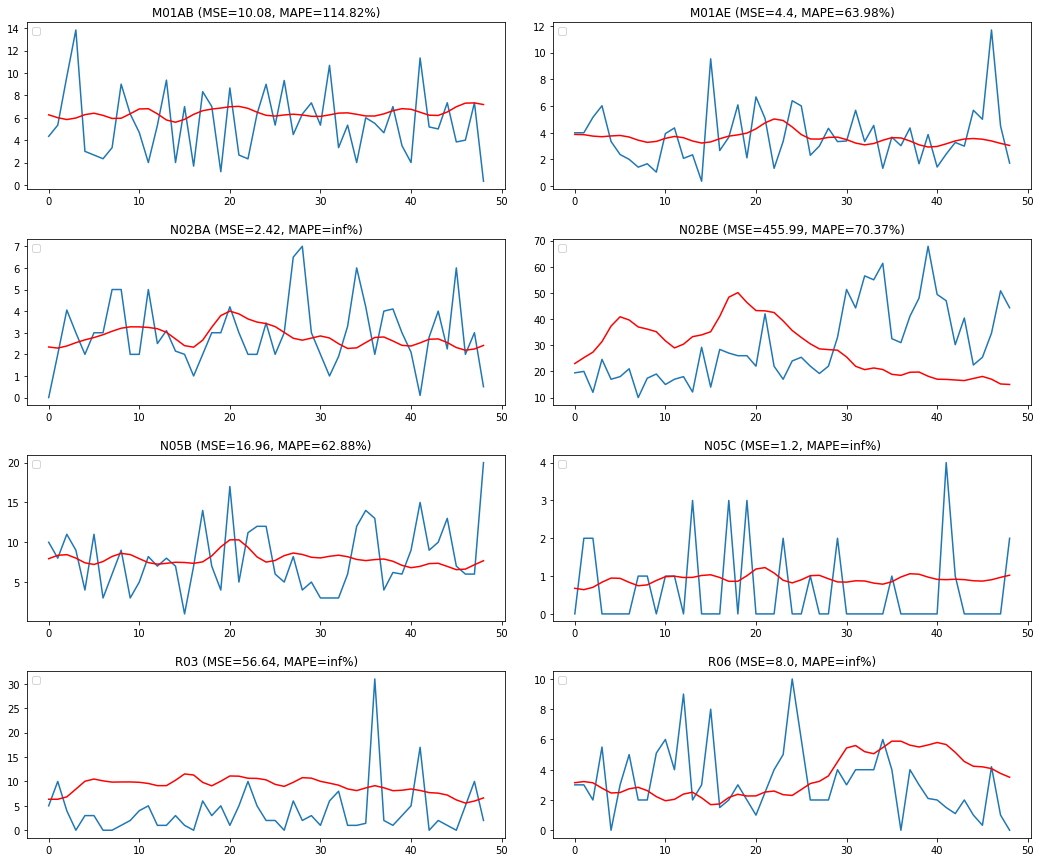

In [38]:
#Previsioni a lungo termine

df: list = pd.read_csv('./salesdaily.csv')

subplotindex: int = 0
numrows: int = 4
numcols: int = 2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB: dict = {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE: dict = {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA: dict = {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE: dict = {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B: dict = {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C: dict = {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03: dict = {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06: dict = {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r: list = [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex: int = math.floor(subplotindex/numcols)
    colindex: int = subplotindex-(rowindex*numcols)
    dfg: list = df[['datum',x['series']]]
    dfg: list = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size: int = int(len(dfg) - 50)
    dfgtrain: list = dfg.loc[0:size,:]
    dfgtest: list = dfg.loc[size+1:len(dfg),:]
    predictions: list = list()
    model = fbprophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'], 
                              daily_seasonality=False, 
                              weekly_seasonality=False
                           )
    if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
        model = model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions = output.loc[size+2:len(dfg),:]['yhat'].values
    
    error: float = mean_squared_error(dfgtest['y'].values, predictions)
    perror: float = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']] = error
    resultsLongtermdf.loc['Prophet MAPE',x['series']] = perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex: int = subplotindex+1
plt.show()

In [39]:
#Risultati previsioni a lungo termine

print('Results for MSE and MAPE short term forecasting')
display(HTML(resultsLongtermdf.to_html()))

Results for MSE and MAPE short term forecasting
